# <ins>Sentiment Analysis: "Covid Vaccine" on Twitter</ins>

# Exploratory Data Analysis

## Overview
With any form of unstructured text data, there exists an abundance of information to extrapolate. In this case, working with tweets about the Covid vaccine, the concepts I wanted explore are 
1) what the breakdown of sentiment over time has been this year

2) what sorts of words are common in each of the three classes (positive, negative, neutral) and how they resemble one another or more likely differ 

3) ideally extract the distict features from each to help address the lack of trust in the vaccines that are now FDA approved

Without having the time or the resources to manually tag all of the tweets I scraped, I began this process by using Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://github.com/cjhutto/vaderSentiment)) to establish a baseline measure for classification and led to valuable insights. During the modeling process this will serve as my target variable when predicting classes on my test set and even tweets from future date ranges.

Using Matplotlib, Seaborn, and Wordclouds I created a number of visuals that help depict the data and provide insights to analysis. And then using a combination of Natural Language Toolkit ([NLTK](https://www.nltk.org/)) and [SpaCy](https://spacy.io/) I preprocessed the corpus in preparation for the modeling stage (found in the [modeling](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/04_modeling.ipynb) notebook). Finally I began to explore topic modeling with [gensim](https://radimrehurek.com/gensim/index.html).

In [1]:
# standard Python packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

# specialized NLP packages
from wordcloud import WordCloud
import spacy, re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy.lang.en import English
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download('wordnet')
nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess

# personalized functions and autoreload updates
from src.functions import * 
%load_ext autoreload
%autoreload 2

# optimize viewing
pd.set_option('max_colwidth', 150)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# unpickle the dataframe
df = pd.read_pickle('./data/clean_df.pkl')

In [3]:
# confirm shape and datatypes are intact
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77259 entries, 0 to 80729
Data columns (total 7 columns):
date         77259 non-null datetime64[ns]
tweet        77259 non-null object
username     77259 non-null object
link         77259 non-null object
nlikes       77259 non-null int64
nreplies     77259 non-null int64
nretweets    77259 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 4.7+ MB


## VADER Sentiment Classification
Using VADER allowed me to establish a basis for my classification without having to manually tag each of my tweets. The package was built and trained using social media-like text for sentiment analysis and is **particularly adept** at picking up on common social media trends like:

- emoticons (*happy*: ':)', *sad*: ':(', *angry*: '>:\[')
- acronyms ('LOL' and 'WTF')
- slang

**It is important to note that while VADER does a good job of picking up on the overall sentiment of a tweet by giving each tweet and giving it a percent positive, percent negative, percent neutral, and overall compound score, the machine cannot actually understand the language (in this case English).** There are a number of instances I noticed where the overall sentiment of a tweet clearly conveying negative sentiment, but the object of that negative sentiment was something other than the COVID-19 vaccine. So, while VADER may have correctly tagged a tweet as negative in its tone, it could and should probably be tagged as a tweet with positive sentiment towards a vaccine. With more time I would ideally like to have a crowd-sourced voting system to classify tweets as ground truth for our classification.

In [4]:
# use vader compound (or composite) score to evaluate the tweet sentiment
vader = SentimentIntensityAnalyzer()

df['vader_score'] = df['tweet'].apply(lambda x: vader.polarity_scores(x)['compound'])

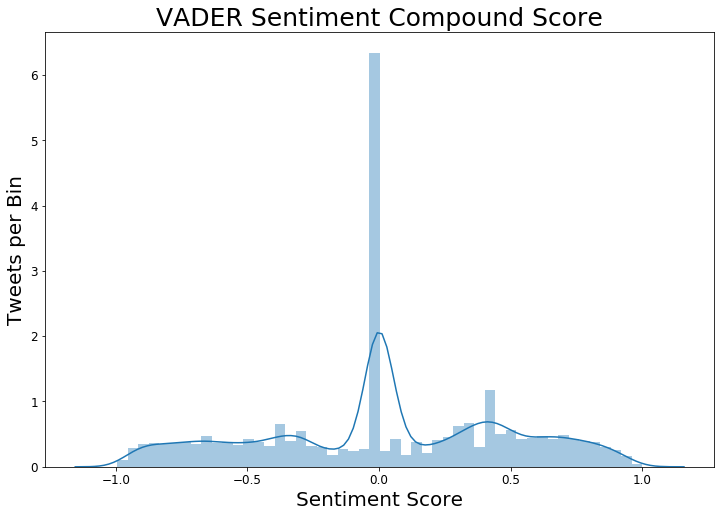

In [5]:
# plot the distribution of 'vader_score'
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(df['vader_score'])
plt.title('VADER Sentiment Compound Score', fontsize=25)
plt.xlabel('Sentiment Score', fontsize=20)
plt.ylabel('Tweets per Bin', fontsize=20)
plt.tick_params(labelsize='large')
plt.savefig('images/vader_sent_dist.png');

Looking at the graph above we see it follows a relatively normal curve, with an overwhelming amount of tweets hovering just below the net-neutral sentiment score and the rest of the tweets being more evenly distributed in both of the tails. 

Using VADER's recommended scoring method, I binned the tweets with a compound sentiment score below -.05 in the negative class, and those above .05 in the positive bin, with the remainder falling into the neutral bin.

In [6]:
# classify tweets based on their vader score less than -.05 'negative', greater than .05 'positive'
# 'neutral' in between
conditions = [
    df['vader_score'] >= .05,
    df['vader_score'] <= -.05
]

classes = ['positive', 'negative']

df['vader_sentiment'] = np.select(conditions, classes, 'neutral')

Binning the tweets by sentiment this way left me with a slight class imbalance, but I won't play around with the scoring too much, as it is relatively even.

In [7]:
# breakdown of classes
df.vader_sentiment.value_counts()

positive    31095
negative    25703
neutral     20461
Name: vader_sentiment, dtype: int64

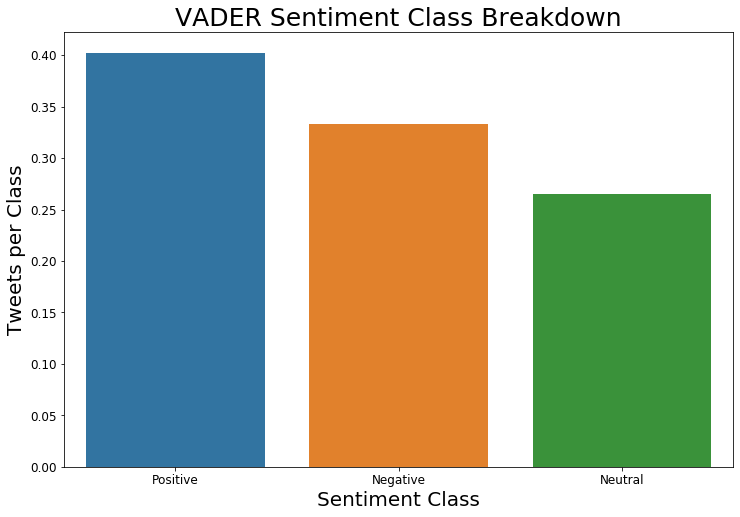

In [8]:
# plot breakdown of classes
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=['Positive', 'Negative', 'Neutral'], y=df['vader_sentiment'].value_counts(normalize=True))
plt.title('VADER Sentiment Class Breakdown', fontsize=25)
plt.xlabel('Sentiment Class', fontsize=20)
plt.ylabel('Tweets per Class', fontsize=20)
plt.tick_params(labelsize='large')
plt.savefig('images/class_bar.png');

The barchart above displays the class imbalance. My data is broken up into about **40% positive tweets, 35% negative tweets, and 25% neutral tweets.** This is nothing to worry about. It's not so dramatic of a difference that my classifier wouldn't be able to simply guess the majority class most of the time (that would prove especially difficult with a multiclass classification problem such as this).

## Text Preprocessing

Preprocessing text data is a multistep process. After much experimentation and exploration with the preprocessing tools available to me (NLTK, SpaCy, Regex) I ended up modifying a preprocessing function originally written by Zijing Zhu ([here](https://towardsdatascience.com/a-step-by-step-tutorial-for-conducting-sentiment-analysis-a7190a444366)) for preprocessing articles. With more time I would like to write my own original function that is highly specialized to help preprocessing twitter data.

The function (found in the [.py file](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/src/functions.py)) takes in the tokenized text, removes unneeded characters and empty strings, and then rejoins the words in lowercase that are not part of my updated stopwords list. To the premade list I've added 'covid', '#covid', 'virus', '#virus', 'coronavirus', '#coronavirus', 'vaccine', '#vaccine', 'vaccines', '#vaccines', 'covid-19', and 'covidvaccine'.

In [9]:
# instantiate spacy english
nlp = English()

In [10]:
# tokenize, remove punctuation, and lemmatize
df['tweet_lemms'] = df['tweet'].apply(lambda x: [token.lemma_ for token in nlp(x) if not token.is_punct])

In [11]:
# apply tweet_preprocessing function to lemmatized tweets
df['clean_tweets'] = df['tweet_lemms'].apply(lambda x: tweet_preprocessing(x))

In [12]:
# observe the cleaned tweets
df['clean_tweets'].head(3)

0    everyone compare flu reminder even flu kill ten thousand year imagine much deadly assurance develope affordable hello pandemic
1            perhaps much type medicine success depend cooperation everyone protect young promise need massive buy population large
2                     provide pharmaceutical company opportunity develop drug soon possible reach mass production know drug produce
Name: clean_tweets, dtype: object

In [13]:
# saving dataframe with preprocessed tweets for use in modeling
# df.to_pickle('data/modeling_df.pkl')

## Wordclouds, Frequency Distributions, and Bar Charts
These visuals will help me to get a clearer understanding of what kinds of words are pervasive throughout the data.

In [14]:
clean_tweets = df['clean_tweets']

In [15]:
# instantiate tokenizer
tokenizer = TweetTokenizer(strip_handles=True)

# make one large string of text
all_words = ' '.join(clean_tweets)

# tokenize the large string for analysis
all_tokens = tokenizer.tokenize(all_words)

In [16]:
len(all_tokens)

1076627

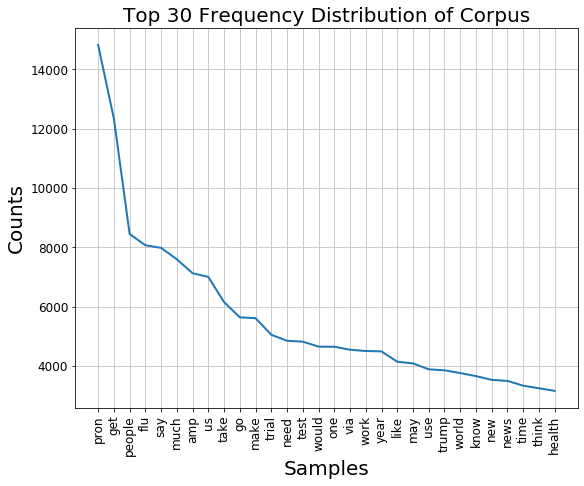

<Figure size 432x288 with 0 Axes>

In [17]:
# plot frequency distribution
fdist = FreqDist(all_tokens)
plt.figure(figsize=(9,7))
plt.title('Top 30 Frequency Distribution of Corpus', fontsize=20)
plt.xlabel('Samples', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize='large')
fdist.plot(30)
plt.savefig('images/first_fdist.png');

The first observation from the distplot above is "what is 'pron'?" It's certainly not a lemma that I recognize, so I did some further digging to explore the origins of this supposedly top occuring word in my dataset of tweets.

On top of that, there are certainly some more words I would like to remove and add to the stopwords list as they are not providing me with much information regarding the subject of the tweets themselves. 

In [18]:
pron = [x for x in clean_tweets if 'pron' in x]

In [19]:
len(pron)

11685

In [20]:
pron[:10]

['jefferson county department health @jcdhtweets say pron work local school hospital prepare spread officials advise practice good hand wash clean surface often get flu httpstcozojpjqg',
 '@kimmcleese @ievil @cphocanada point sars cov fatality rate flu also asymptomatic carrier think china lock million people pron another flu think xijingping idiot like @justintrudeau',
 '@marcorubio wholesale drop every ball complete absence coherent strategy address issue politicize well people close risk mitigation strat pron lie contain friend',
 '@gijoeabn @cnn never symptom state capacity test cdc must approve test comparing flu dishonest china intentionally report pron number',
 'pron go take lot long make treatment httpstcokyvwiigea',
 'wait get pron go happen unless soon pron pretty much guarantee point',
 '@seekhelplibs @jennfranconews @oann kill people time rate flu doe help mitigate disease pron big deal',
 'worry yes pron something worry flu season year flu claim live vaccinate come take',

In [21]:
df.loc[df['tweet'].str.contains('pron')]

,date,tweet,username,link,nlikes,nreplies,nretweets,vader_score,vader_sentiment,tweet_lemms,clean_tweets
192,2020-02-28,@5StarVictory COVID-19 is exponentially more contagious/prone to spreading than normal influenza. Epidemiologists are speculating it might even ha...,ChaosKing6321,https://twitter.com/ChaosKing6321/status/1233473889449238529,1,1,0,-0.8052,negative,"[@5StarVictory, COVID-19, be, exponentially, much, contagious, prone, to, spread, than, normal, influenza, Epidemiologists, be, speculate, it, may...",@starvictory exponentially much contagious prone spread normal influenza epidemiologists speculate may even airborne transmission serious unlike v...
1139,2020-02-27,@KristieAnn Then they should definitely use the same flu prevention precautions (minus a vaccine obviously) they are already employing. They are s...,Antigone,https://twitter.com/Antigone/status/1233102751338381312,0,1,0,-0.4199,negative,"[@KristieAnn, Then, they, should, definitely, use, the, same, flu, prevention, precaution, minus, a, vaccine, obviously, they, be, already, employ...",@kristieann definitely use flu prevention precaution minus obviously already employ statistically much prone common flu wash hand anti bacterial g...
3193,2020-02-24,COVID-19 is uncontainable at this point I’d say. Will probably join the ranks of the seasonal flu unless a vaccine is developed at scale to squas...,mrjasonray,https://twitter.com/mrjasonray/status/1231975059457282049,0,0,0,0.3400,positive,"[COVID-19, be, uncontainable, at, this, point, -PRON-, ’d, say, , Will, probably, join, the, rank, of, the, seasonal, flu, unless, a, vaccine, be...",uncontainable point pron say probably join rank seasonal flu unless develope scale squash hoping pron prone antigenic drift
6228,2020-03-30,"@Whelts @GuyVerhoftwat Yep, he did and it looks like Covid-19 neither heard or cared. Infections and death continue in the States Also, the other...",Bexit5,https://twitter.com/Bexit5/status/1244673774320058368,1,0,0,-0.3678,negative,"[@Whelts, @GuyVerhoftwat, Yep, he, do, and, it, look, like, Covid-19, neither, hear, or, care, Infections, and, death, continue, in, the, States, ...",@whelts @guyverhoftwat yep look like neither hear care infections death continue states also week pronounce folk heal pron call
8215,2020-03-30,It depends how many have cancer and are near end of life are going to be counted. Most of us will probably get Covid in the next few years becaus...,RealBurnMan,https://twitter.com/RealBurnMan/status/1244486330656194560,0,0,0,-0.6808,negative,"[It, depend, how, many, have, cancer, and, be, near, end, of, life, be, go, to, be, count, , Most, of, us, will, probably, get, Covid, in, the, n...",depend many cancer near end life go count us probably get next year cover every prong strain
8815,2020-03-29,@channelstv Buhari is a disgrace to Nigeria!!! Upon all the global insult and rehearsals and edits yet he can't still pronounce Covid-19.. And he ...,ShakaOkeke,https://twitter.com/ShakaOkeke/status/1244394803921596416,0,0,0,-0.8547,negative,"[@channelstv, Buhari, be, a, disgrace, to, Nigeria, Upon, all, the, global, insult, and, rehearsal, and, edit, yet, he, can, not, still, pronounce...",@channelstv buhari disgrace nigeria upon global insult rehearsal edit yet still pronounce call avazin
10954,2020-03-29,@ForebodingRaven @StraightIC1Male @hook_nick @gower_ray @10DowningStreet @BorisJohnson COVID-19 is a single stand RNA virus and as such is highly ...,XeNoxMuRKaGe,https://twitter.com/XeNoxMuRKaGe/status/1244166809949003776,1,1,0,-0.7574,negative,"[@ForebodingRaven, @StraightIC1Male, @hook_nick, @gower_ray, @10DowningStreet, @BorisJohnson, COVID-19, be, a, single, stand, RNA, virus, and, a, ...",@forebodingraven @straighticmale @hooknick @gowerray @downingstreet @borisjohnson single stand rna highly prone mutation already two know strain p...
11516,2020-03-28,"Four prongs to combat #Covid 1: spatial distancing, do it now 2: testing , rapid advances, 15 min tests coming wit

From first glance, 'pron' could be caught by a wide variety of larger words, the most common being 'prone', but there are other examples here of 'pron' coming from 'pronounce', 'prongs', 'pronouncement', and 'pronto'. All of these samples could have been tokenized down to 'pron'. For my purposes, I am going to remove the word and continue with words that give me more of a sense of significance to the messages being conveyed.

In [22]:
# update stopwords with meaningless top words
stop_words.extend(['get', 'people', 'say', 'much', 'amp',
                   'take', 'go', 'make', 'need', 'would',
                   'one', 'via', 'like', 'may', 'use',
                   'know', 'pron', 'come', 'even', 'many',
                   'see', 'still', 'us', 'year', 'world', 
                   'new', 'news', 'time', 'think', 'good', 
                   'pandemic', 'want', 'china', 'human', 
                   'month', 'country', 'work', 'also', 'way'])

In [23]:
# remove new stopwords     
all_tokens = [word for word in all_tokens if word not in stop_words]

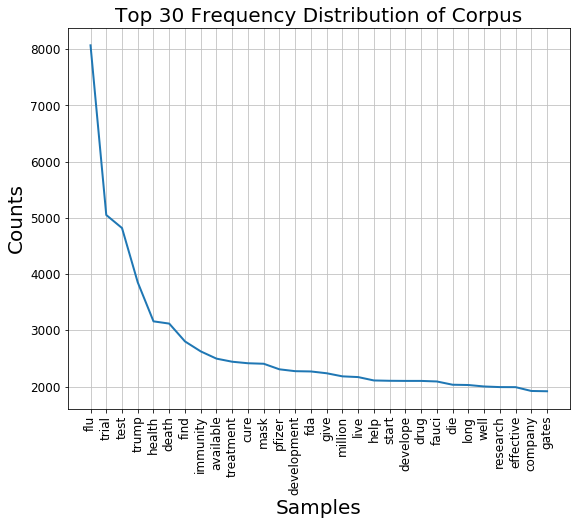

<Figure size 432x288 with 0 Axes>

In [24]:
# updated fdist
fdist = FreqDist(all_tokens)
plt.figure(figsize=(9,7))
plt.title('Top 30 Frequency Distribution of Corpus', fontsize=20)
plt.xlabel('Samples', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize='large')
fdist.plot(30)
plt.savefig('images/second_fdist.png');

After a few iterations of removing stopwords of little or no significance, I finally see here a frequency distribution of lemmatized and lowercased tokens that make sense in the context of the problem. I would expect to see all of these words in tweets concerning the covid vaccine. Now I'll check to see if there are any notable distinctions between the classes.

# Exploring More Extreme VADER Scoring
Simply in the name of exploration and a desire to see what exists at the more extreme poles of this sentiment scale, I've made two groups of highly positive and highly negative tweets, where I adjusted the thresholds for those sentiments to 0.5 and -0.5. Hopefully this will help me understand what the more intense ideologies are at play in this discussion over a Coronavirus vaccine.

In [25]:
# higher threshold for higher class distinction
highly_pos = df[df['vader_score'] >= .5]
highly_neg = df[df['vader_score'] <= -.5]

In [26]:
# separate extreme clean tweets
clean_pos_tweets = highly_pos['clean_tweets']
clean_neg_tweets = highly_neg['clean_tweets']

# make one large string of text
all_pos_words = ' '.join(clean_pos_tweets)
all_neg_words = ' '.join(clean_neg_tweets)

# tokenize the large string for analysis
all_pos_tokens = tokenizer.tokenize(all_pos_words)
all_neg_tokens = tokenizer.tokenize(all_neg_words)

# remove stop words
all_pos_tokens = [word for word in all_pos_tokens if word not in stop_words]
all_neg_tokens = [word for word in all_neg_tokens if word not in stop_words]

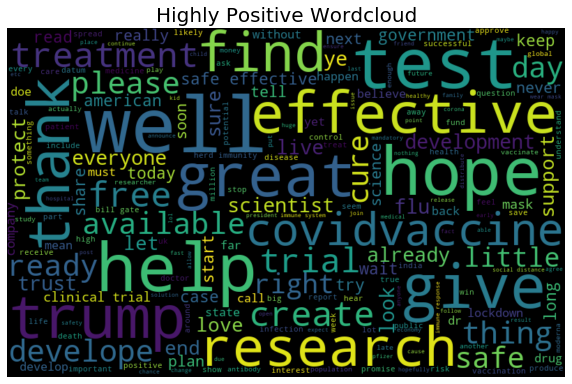

In [27]:
# rejoin all positive tokens without stops
pos_cloud = ' '.join([token for token in all_pos_tokens])

# instantiate wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(pos_cloud)

# plot cloud
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Highly Positive Wordcloud', fontsize=20)
plt.savefig('images/highly_pos_cloud.png');

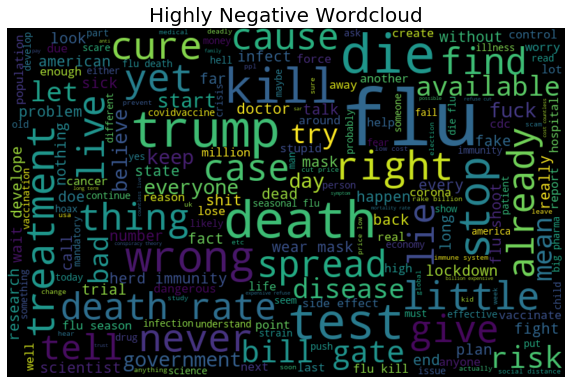

In [28]:
# rejoin all positive tokens without stops
neg_cloud = ' '.join([token for token in all_neg_tokens])

# instantiate wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(neg_cloud)

# plot cloud
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Highly Negative Wordcloud', fontsize=20)
plt.savefig('images/highly_neg_cloud.png');

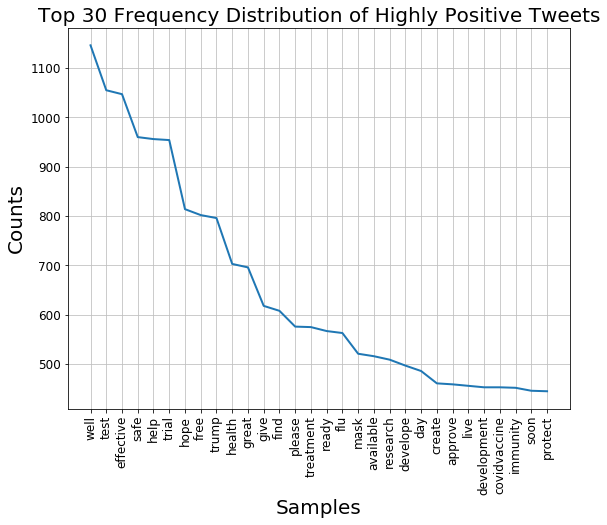

<Figure size 432x288 with 0 Axes>

In [29]:
# updated fdist
fdist = FreqDist(all_pos_tokens)
plt.figure(figsize=(9,7))
plt.title('Top 30 Frequency Distribution of Highly Positive Tweets', fontsize=20)
plt.xlabel('Samples', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize='large')
fdist.plot(30)
plt.savefig('images/pos_fdist.png');

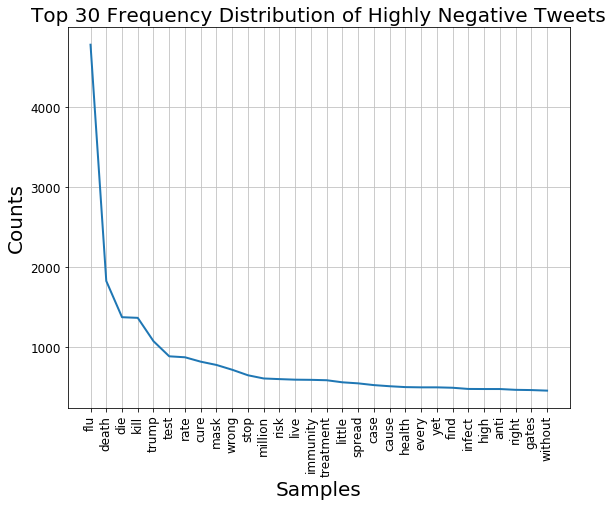

<Figure size 432x288 with 0 Axes>

In [30]:
# updated fdist
fdist = FreqDist(all_neg_tokens)
plt.figure(figsize=(9,7))
plt.title('Top 30 Frequency Distribution of Highly Negative Tweets', fontsize=20)
plt.xlabel('Samples', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize='large')
fdist.plot(30)
plt.savefig('images/neg_fdist.png', bbox_inches='tight');

When I look at the two distribution plots, I do not notice too many significant differences between the two extremes. Perhaps language is similar in the two camps, but sentiment is differed. There are slight alterations in the order of frequency and a noticeable difference in the shape of the two plots. You'll see that the Positive class has a more linear distribution, while the Negative class looks more like a 1/x curve. Looking closely you'll notice the words 'flu', 'death', and 'die' occur much more in the negative class and distorts the scale of the two graphs in comparison. Without those three words, the graphs would look more similar in shape.

In the Negative class the word 'immunity' appears higher on the list probably as people discussed immune system responses to the new virus and the concept of 'herd-immunity' which would still cost thousands more lives for the world to arrive at that level of immunity on its own.

The other differences I notice are to be expected. In the positive tweets we see words like 'effective,' 'safe,' 'help,' 'treatment,' and 'ready.' On the negative tweets we see more words like 'flu,' 'test,' 'rate,' 'immunity,' and 'spread.' But for there to be more significant conclusions and generalizations made, I would need much more data and more time to do further analysis. 

## Sentiment Over Time

In [31]:
# setup a new dataframe with a compound index of date and sentiment classes
df_time = df.set_index(['date', 'vader_sentiment'])

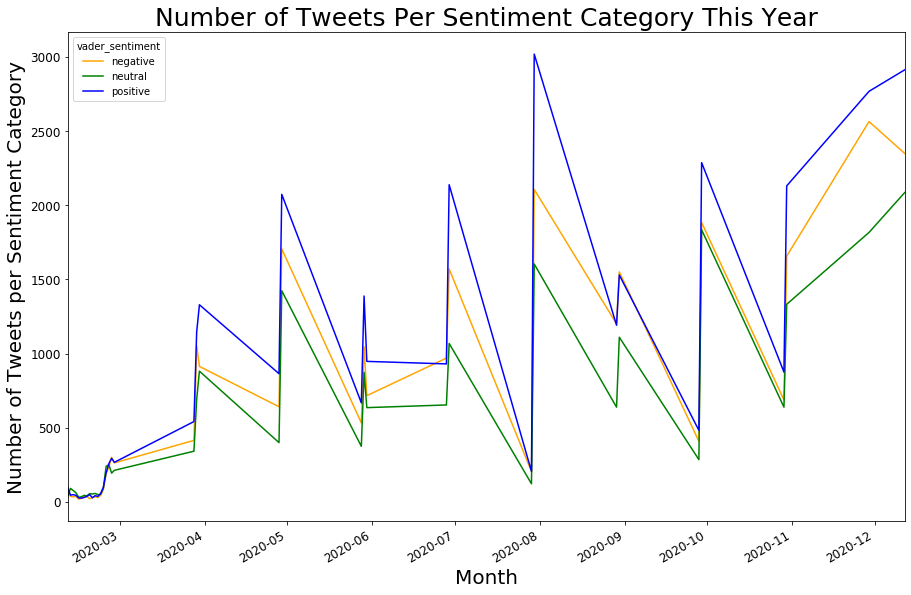

In [32]:
# plot tweet sentiment over time
fig, ax = plt.subplots(figsize=(15,10))
df_time.groupby(['date', 'vader_sentiment']).count()['tweet'].unstack().plot(
    ax=ax, color=('orange', 'green', 'blue'))
plt.title('Number of Tweets Per Sentiment Category This Year', fontsize=25)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of Tweets per Sentiment Category', fontsize=20)
plt.tick_params(labelsize='large')
plt.savefig('images/sentiment_over_time_line.png');

Key takeaways from this graph:
1) There is almost no tweeting about any vaccine until the **end of March when COVID-19 really began** to overwhelm the U.S.

2) The end of June and the beginning of September are the **only points at which we see the amount of negative tweets exceeding the amount of positive tweets**, otherwise the lines don't seem to cross each other and follow the same general trends

3) There is a **general upward trend** of more and more tweets about the COVID-19 vaccine as it gets closer and closer to being approved by the FDA for the public in early December

## LDA Topic Modeling

In [33]:
# split the clean tweets into lists of words
lda_tweets = df['clean_tweets'].apply(lambda x: x.split(' '))

In [34]:
# observe breakdown of tweets
lda_tweets[:5]

0        [everyone, compare, flu, reminder, even, flu, kill, ten, thousand, year, imagine, much, deadly, assurance, develope, affordable, hello, pandemic]
1                  [perhaps, much, type, medicine, success, depend, cooperation, everyone, protect, young, promise, need, massive, buy, population, large]
2                             [provide, pharmaceutical, company, opportunity, develop, drug, soon, possible, reach, mass, production, know, drug, produce]
3    [john, hopkins, immediate, risk, remain, low, us, well, way, protect, practice, precaution, would, use, prevent, spread, respiratory, disease, cur...
4                                                                                      [stockmarkets, keep, fall, confident, fund, available, development]
Name: clean_tweets, dtype: object

In [35]:
# creating a dictionary of my lemmatized words
dictionary = gensim.corpora.Dictionary(lda_tweets)

In [36]:
# filter out words that appear in less than 5 tweets or more than 50% of tweets
dictionary.filter_extremes()

In [37]:
# this should change based on the randomness of gensim
len(dictionary)

12038

In [38]:
# bag of words corpus
bag_corpus = [dictionary.doc2bow(tweet) for tweet in lda_tweets]

In [39]:
# lda model will output 10 topics
lda_model = gensim.models.LdaMulticore(bag_corpus, num_topics=10, id2word=dictionary, passes=10, workers=2)

In [40]:
# topics based on bag of words modeling
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.031*"development" + 0.026*"via" + 0.015*"@youtube" + 0.013*"lab" + 0.011*"race" + 0.011*"south" + 0.010*"read" + 0.009*"new" + 0.009*"vaccination" + 0.009*"australia"
Topic: 1 
Words: 0.025*"health" + 0.012*"public" + 0.012*"amp" + 0.010*"company" + 0.009*"free" + 0.009*"much" + 0.008*"medical" + 0.008*"plan" + 0.008*"big" + 0.008*"pharma"
Topic: 2 
Words: 0.034*"get" + 0.031*"pron" + 0.024*"people" + 0.020*"flu" + 0.016*"much" + 0.013*"take" + 0.012*"go" + 0.012*"year" + 0.010*"death" + 0.009*"like"
Topic: 3 
Words: 0.016*"covidvaccine" + 0.016*"hiv" + 0.011*"disease" + 0.010*"arrive" + 0.010*"sars" + 0.009*"case" + 0.009*"india" + 0.009*"operation" + 0.007*"infection" + 0.007*"corona"
Topic: 4 
Words: 0.027*"biden" + 0.026*"amp" + 0.019*"@pfizer" + 0.016*"johnson" + 0.015*"lead" + 0.014*"expert" + 0.014*"candidate" + 0.013*"use" + 0.013*"pm" + 0.013*"supply"
Topic: 5 
Words: 0.052*"pfizer" + 0.051*"fda" + 0.047*"trial" + 0.032*"emergency" + 0.032*"approve" + 0.022*

## Final Thoughts
In this notebook I prepared the data for the modeling process, took a deep dive into what the data can tell us about the differences between the 3 classes, and began to model my data with gensim topic modeling. In the next notebook [04_modeling](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/04_modeling.ipynb), I'll take my preprocessed data from here and see how well a classification model can distinguish between the three.